In [167]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout, BatchNormalization, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers
import yfinance as yf

In [179]:
# managing dataset
df = yf.download("AAPL", start="2015-01-01", end="2025-05-31", interval="1d")

# removing the date index and making it a column
df.reset_index(inplace=True)

# the column names were a tuple so to make the name linear we joined the values present in one tuple
df.columns = ['_'.join(col).strip() for col in df.columns.values]

/var/folders/fy/dxp741tx4fb46nshth9jsh5m0000gn/T/ipykernel_85336/1309230987.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2025-05-31", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [169]:
# feature engineering to add new features 

# Basic price features
# high low pct tells how much price of stock fluctuated with respect to closing price.It represents volatility,more volatility,more risk
# 📈 High_Low_Pct → Volatility / Intraday Risk
df['High_Low_Pct'] = (df['High_AAPL'] - df['Low_AAPL']) / df['Close_AAPL']
# it tells percentage return for that day closing-opening price. it tells the momentum of market
# 📉 Open_Close_Pct → Market Sentiment / Momentum
df['Open_Close_Pct'] = (df['Close_AAPL'] - df['Open_AAPL']) / df['Open_AAPL']

# Lag features (shorter lags are more predictive)
# provide historical context
for lag in [1, 2, 3, 5]:
    df[f'Close_lag{lag}'] = df['Close_AAPL'].shift(lag)
    df[f'Volume_lag{lag}'] = df['Volume_AAPL'].shift(lag)
    #The percentage return between t and t - lag.
    df[f'Return_lag{lag}'] = df['Close_AAPL'].pct_change(lag)
    
# Moving averages with different windows
for window in [5, 10, 20, 50]:
        df[f'MA_{window}'] = df['Close_AAPL'].rolling(window=window).mean()
        df[f'MA_{window}_ratio'] = df['Close_AAPL'].values / df[f'MA_{window}'].values

# Volatility features
#Low std = stable trend, High std = choppy or breakout zone.
df['Rolling_std_5'] = df['Close_AAPL'].rolling(window=5).std()
df['Rolling_std_10'] = df['Close_AAPL'].rolling(window=10).std()
df['Rolling_std_20'] = df['Close_AAPL'].rolling(window=20).std()
        
# Volume features
df['Volume_MA_5'] = df['Volume_AAPL'].rolling(window=5).mean()
df['Volume_MA_20'] = df['Volume_AAPL'].rolling(window=20).mean()
df['Volume_ratio_5'] = df['Volume_AAPL'] / df['Volume_MA_5']
df['Volume_ratio_20'] = df['Volume_AAPL'] / df['Volume_MA_20']

#RSI (Relative Strength Index) measures the speed and magnitude of recent price changes to determine whether an asset is 
#overbought or oversold
# bound between 0-100 and determines moementum and strenght
# When RSI > 70 → market might be overheated, due for correction.Overbought (price may drop soon)
# When RSI < 30 → price might rebound.Oversold (price may rise soon)
def compute_rsi(series, period=14):
            delta = series.diff()                        # Price change per day
            gain = delta.clip(lower=0)                  # Only keep positive changes
            loss = -1 * delta.clip(upper=0)             # Only keep negative changes (as positive values)
            avg_gain = gain.rolling(window=period).mean() # Average gain over 14 days
            avg_loss = loss.rolling(window=period).mean() # Average loss over 14 days
            rs = avg_gain / avg_loss                    # Relative Strength (RS)
            rsi = 100 - (100 / (1 + rs))                # RSI formula
            return rsi
        
df['RSI_14'] = compute_rsi(df['Close_AAPL'], 14)
df['RSI_7'] = compute_rsi(df['Close_AAPL'], 7)

# MACD
#MACD is a momentum + trend-following indicator that measures the difference between two EMAs (Exponential Moving Averages).
# Is short-term momentum rising faster than long-term trend?”
# If yes → bullish signal. If not → bearish signal.
# MACD Line ↑ above Signal Line → Bullish signal
# Price is gaining short-term momentum.
# MACD Line ↓ below Signal Line → Bearish signal
# Price is losing momentum.
# Histogram > 0 → Momentum is building up.
# Histogram < 0 → Downward momentum is increasing.
#The signal line is a smoothed moving average of the MACD line itself. It's used to identify trend reversals or confirmations.
ema_12 = df['Close_AAPL'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close_AAPL'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

# Bollinger Bands
# Bollinger Bands are a set of three lines plotted around a stock's price:

# Middle Band = 20-day Simple Moving Average (ma_20)

# Upper Band = Middle Band + 2× standard deviation

# Lower Band = Middle Band − 2× standard deviation

# What Bollinger Bands Represent:
# They enclose the stock price within a volatility-adjusted range.

# As volatility increases → bands widen

# As volatility decreases → bands contract

# Price tends to mean revert back to the middle band (like a spring).


ma_20 = df['Close_AAPL'].rolling(window=20).mean()
std_20 = df['Close_AAPL'].rolling(window=20).std()
df['BB_upper'] = ma_20 + 2 * std_20
df['BB_lower'] = ma_20 - 2 * std_20
df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / ma_20
df['BB_position'] = (df['Close_AAPL'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

# Price momentum
for period in [3, 5, 10]:
    df[f'Momentum_{period}'] = df['Close_AAPL'] / df['Close_AAPL'].shift(period) - 1

# Returns
df['Daily_Return'] = df['Close_AAPL'].pct_change()
df['Return_std_5'] = df['Daily_Return'].rolling(window=5).std()
df['Return_std_20'] = df['Daily_Return'].rolling(window=20).std()

# Price position relative to recent highs/lows
df['High_20'] = df['High_AAPL'].rolling(window=20).max()
df['Low_20'] = df['Low_AAPL'].rolling(window=20).min()
df['Price_position_20'] = (df['Close_AAPL'] - df['Low_20']) / (df['High_20'] - df['Low_20'])
        


In [170]:
df

,Date_,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,High_Low_Pct,Open_Close_Pct,Close_lag1,Volume_lag1,...,BB_position,Momentum_3,Momentum_5,Momentum_10,Daily_Return,Return_std_5,Return_std_20,High_20,Low_20,Price_position_20
0,2015-01-02,24.288584,24.757338,23.848709,24.746230,212818400,0.037410,-0.018494,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000,0.030494,-0.018838,24.288584,212818400.0,...,NaN,NaN,NaN,NaN,-0.028172,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,23.606554,23.866479,23.244435,23.668758,263188400,0.026350,-0.002628,23.604332,257142000.0,...,NaN,NaN,NaN,NaN,0.000094,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,23.937569,24.037539,23.704302,23.815381,160423600,0.013921,0.005131,23.606554,263188400.0,...,NaN,-0.014452,NaN,NaN,0.014022,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,24.857309,24.915071,24.148623,24.266369,237458000,0.030834,0.024352,23.937569,160423600.0,...,NaN,0.053083,NaN,NaN,0.038422,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900,0.021713,0.008262,201.360001,46742400.0,...,0.102196,-0.056028,-0.075689,-0.015131,-0.030244,0.010836,0.020871,214.279000,192.99691,0.106808
2614,2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500,0.016533,0.009632,195.270004,78432900.0,...,0.311180,-0.009303,-0.041048,-0.050192,0.025298,0.021511,0.021779,214.279000,192.99691,0.338928
2615,2025-05-28,200.419998,202.729996,199.899994,200.589996,45339700,0.014120,-0.000847,200.210007,56288500.0,...,0.337635,-0.004668,-0.031132,-0.058752,0.001049,0.021873,0.021727,214.279000,192.99691,0.348795
2616,2025-05-29,199.949997,203.809998,198.509995,203.580002,51396800,0.026507,-0.017831,200.419998,45339700.0,...,0.338720,0.023967,-0.010589,-0.058305,-0.002345,0.019716,0.021636,214.279000,192.99691,0.326711


In [171]:
# target columns
threshold=0.002 
future_days=1
df['Future_Close'] = df['Close_AAPL'].shift(-future_days)
df['Price_Change'] = (df['Future_Close'] / df['Close_AAPL'] - 1)

# Use a smaller, more realistic threshold
df['Target'] = (df['Price_Change'] > threshold).astype(int)

# Remove rows where we can't calculate target
df = df[:-future_days]

In [172]:
exclude_cols = ['Date_', 'Target', 'Future_Close', 'Price_Change']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Remove features with too many NaN values
nan_threshold = 0.1  # Remove features with >10% NaN
for col in feature_cols.copy():
    if df[col].isnull().sum() / len(df) > nan_threshold:
        feature_cols.remove(col)

df.dropna(inplace=True)
X = df[feature_cols].values
y = df['Target'].values
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]



/var/folders/fy/dxp741tx4fb46nshth9jsh5m0000gn/T/ipykernel_85336/3753488206.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [173]:
scaler = RobustScaler()
# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_sequences( X, y, sequence_length):
        """Create sequences for LSTM/GRU"""
        X_seq, y_seq = [], []
        for i in range(len(X) - sequence_length):
            X_seq.append(X[i:i + sequence_length])
            y_seq.append(y[i + sequence_length])
        return np.array(X_seq), np.array(y_seq)

# Create sequences
sequence_length=30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train,sequence_length )
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, sequence_length)


In [174]:
# model = Sequential()
        
# # First GRU layer - larger for pattern recognition
# model.add(Bidirectional(GRU(
#     units=64,
#     return_sequences=True,
#     dropout=0.2,
#     recurrent_dropout=0.2,
#     kernel_regularizer=regularizers.l2(1e-4)
# ), input_shape=(X_train_seq.shape[1],X_train_seq.shape[2])))
# model.add(BatchNormalization())

# # Second GRU layer
# model.add(Bidirectional(GRU(
#     units=32,
#     return_sequences=True,
#     dropout=0.2,
#     recurrent_dropout=0.2,
#     kernel_regularizer=regularizers.l2(1e-4)
# )))
# model.add(BatchNormalization())

# # Third GRU layer
# model.add(GRU(
#     units=16,
#     dropout=0.2,
#     recurrent_dropout=0.2,
#     kernel_regularizer=regularizers.l2(1e-4)
# ))
# model.add(BatchNormalization())

# # Dense layers with appropriate regularization
# model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
# model.add(Dropout(0.3))
# model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
# model.add(Dropout(0.2))

# # Output layer
# model.add(Dense(1, activation='sigmoid'))
# model.compile(
#             optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
#             loss='binary_crossentropy',
#             metrics=['accuracy', 'precision', 'recall']
#         )
model = Sequential()
model.add( Bidirectional(GRU(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))))
model.add(Dropout(0.4))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(32)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, X_train_seq.shape[1], X_train_seq.shape[2]))



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [175]:
# this is done in case class imbablances are present in the data. as the class with less examples must be given a little higer
# weight to prevent wrong biased prediction.
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_seq)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))

#The ReduceLROnPlateau callback in Keras/TensorFlow is used to automatically reduce the learning rate when the model stops improving. 
#It helps the model converge more smoothly — especially when the loss gets stuck in a plateau.
#"If the validation loss doesn't improve for 7 epochs, cut the learning rate in half."
#This makes the optimizer take smaller steps when progress slows down — helping it fine-tune weights instead of 
#overshooting or bouncing around minima.
# it avoids manual tuning of learning rate schedules.
# Prevents overfitting by encouraging smaller, careful updates later in training.
# Helps settle into better minima during fine-tuning stages.



callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                mode='max'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-7,
                verbose=0
            )
        ]
history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_test_seq, y_test_seq),
            epochs=60,
            # batch_size=64,
            class_weight=class_weight_dict,
            #callbacks=callbacks,
            
        )

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5231 - loss: 0.7086 - val_accuracy: 0.4731 - val_loss: 0.7157
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5240 - loss: 0.6976 - val_accuracy: 0.4793 - val_loss: 0.7058
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5237 - loss: 0.6898 - val_accuracy: 0.4814 - val_loss: 0.7000
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5232 - loss: 0.6963 - val_accuracy: 0.4917 - val_loss: 0.6969
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5478 - loss: 0.6908 - val_accuracy: 0.4938 - val_loss: 0.7000
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5542 - loss: 0.6849 - val_accuracy: 0.5517 - val_loss: 0.6946
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5476 - loss: 0.6834 - val_accuracy: 0.4835 - val_loss: 0.7038
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5544 - loss: 0.6832 - val_accuracy: 0.5186 - v

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

MODEL EVALUATION RESULTS
Test Accuracy: 0.5393

Classification Report:
              precision    recall  f1-score   support

        Down       0.57      0.51      0.54       253
          Up       0.52      0.57      0.54       231

    accuracy                           0.54       484
   macro avg       0.54      0.54      0.54       484
weighted avg       0.54      0.54      0.54       484



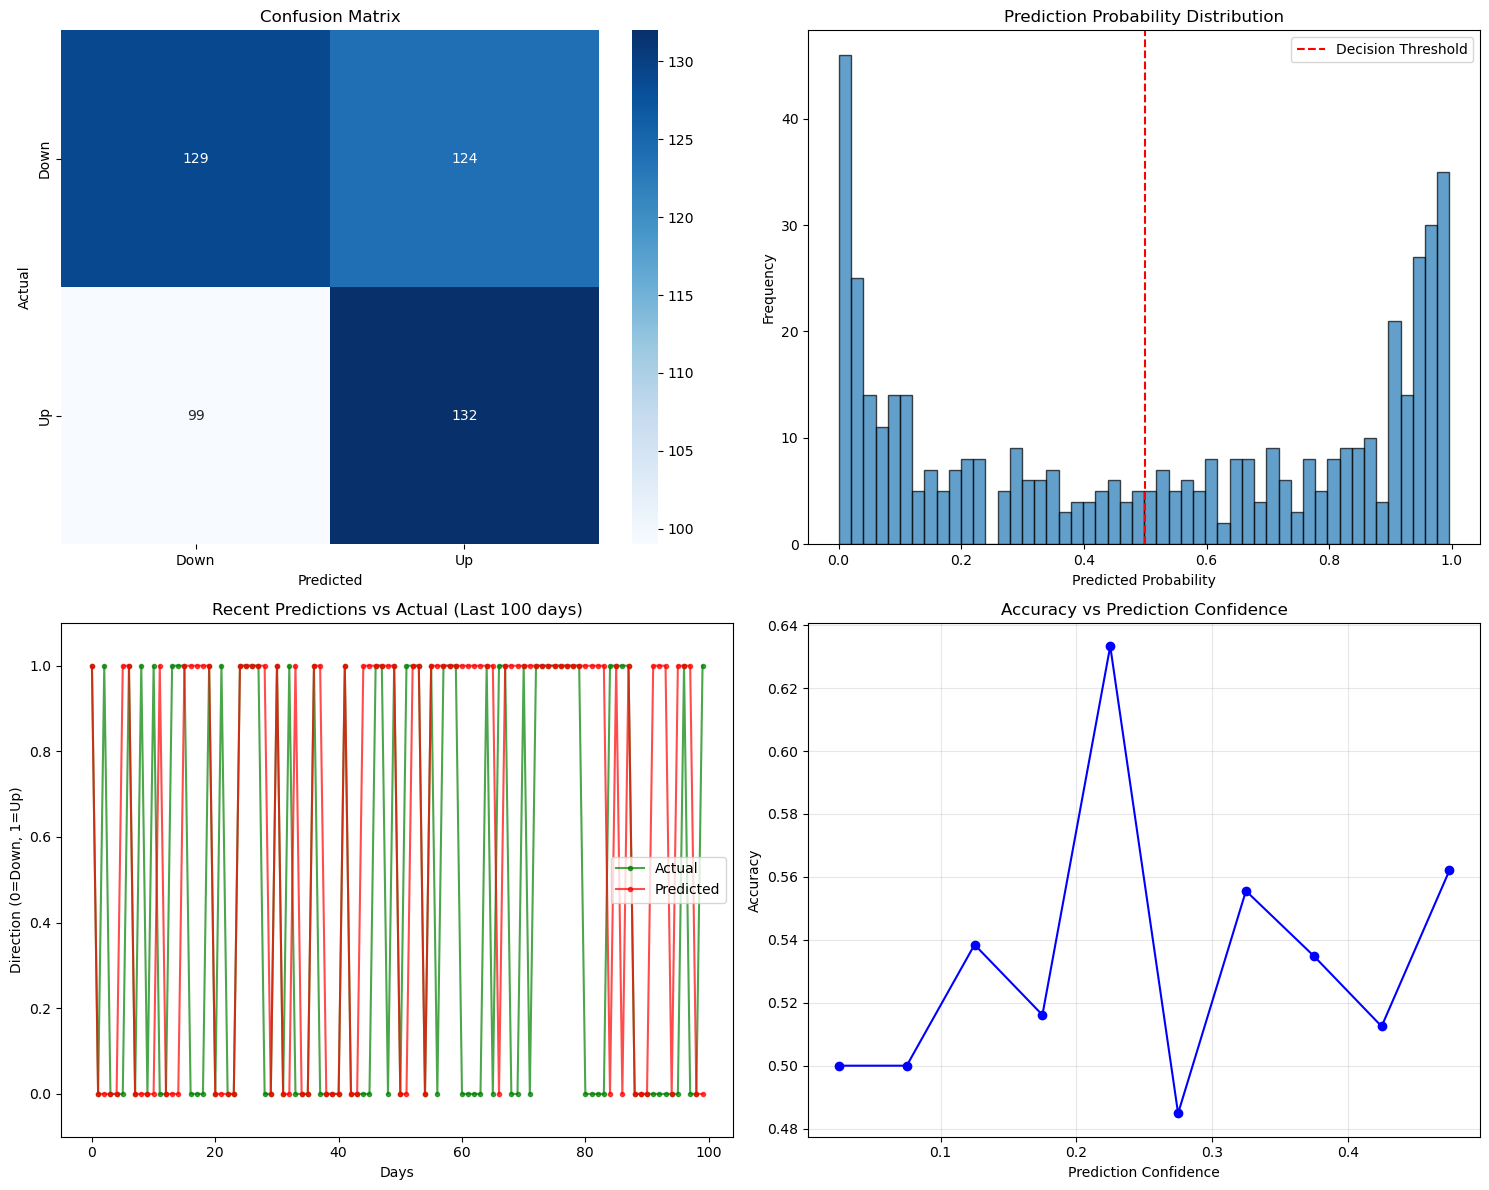

In [176]:
# Predictions
y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Metrics
accuracy = accuracy_score(y_test_seq, y_pred)

print(f"\n{'='*50}")
print(f"MODEL EVALUATION RESULTS")
print(f"{'='*50}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_seq, y_pred, target_names=['Down', 'Up']))

# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# Prediction Distribution
axes[0,1].hist(y_pred_prob, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0,1].set_xlabel('Predicted Probability')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Prediction Probability Distribution')
axes[0,1].legend()

# Recent Predictions vs Actual
recent_len = min(100, len(y_test_seq))
x_recent = range(recent_len)
axes[1,0].plot(x_recent, y_test_seq[-recent_len:], 'go-', label='Actual', alpha=0.7, markersize=3)
axes[1,0].plot(x_recent, y_pred[-recent_len:], 'ro-', label='Predicted', alpha=0.7, markersize=3)
axes[1,0].set_xlabel('Days')
axes[1,0].set_ylabel('Direction (0=Down, 1=Up)')
axes[1,0].set_title(f'Recent Predictions vs Actual (Last {recent_len} days)')
axes[1,0].legend()
axes[1,0].set_ylim(-0.1, 1.1)

# Prediction Confidence Analysis
confidence = np.abs(y_pred_prob.flatten() - 0.5)
correct_predictions = (y_pred.flatten() == y_test_seq).astype(int)

# Bin by confidence and calculate accuracy for each bin
confidence_bins = np.linspace(0, 0.5, 11)
bin_accuracies = []
bin_centers = []

for i in range(len(confidence_bins)-1):
    mask = (confidence >= confidence_bins[i]) & (confidence < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_accuracy = np.mean(correct_predictions[mask])
        bin_accuracies.append(bin_accuracy)
        bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

axes[1,1].plot(bin_centers, bin_accuracies, 'bo-', markersize=6)
axes[1,1].set_xlabel('Prediction Confidence')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Accuracy vs Prediction Confidence')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
